In [4]:
from power_planner.utils import get_donut_vals, get_half_donut, get_distance_surface
from power_planner.constraints import ConstraintUtils
from power_planner.plotting import plot_path, plot_path_costs
import numpy as np
from graph_tool.all import Graph, shortest_path,load_graph, find_edge, remove_labeled_edges
import time
from collections import deque
import matplotlib.pyplot as plt
import os
import json
import pickle
from skimage.segmentation import watershed
from skimage import data, util, filters, color

## Load data and baseline:

In [2]:
instance_path = "/Users/ninawiedemann/Downloads/tifs_new/data_dump_2.dat"
with open(instance_path, "rb") as infile:
    data = pickle.load(infile)
(instance, instance_corr, start_inds, dest_inds) = data.data

In [3]:
LAYER_CLASSES = ['cultural', 'human', 'planning', 'technical']
CLASS_WEIGHT = [0.28571429, 0.35714286, 0.14285714, 0.21428571]
PYLON_DIST_MIN = 7.5
PYLON_DIST_MAX = 12.5
vec = [-69, 216]
MAX_ANGLE = 0.5 * np.pi

In [7]:
with open("../outputs/path_19301_infos.json", "r") as infile:
    infos = json.load(infile)

In [8]:
print(infos["path_cells"])

[[542, 110], [548, 134], [552, 158], [536, 176], [526, 194], [510, 212], [500, 234], [496, 258], [494, 282], [488, 306], [484, 322], [478, 346], [472, 370], [462, 392], [452, 414], [452, 438], [448, 462], [442, 486], [442, 510], [438, 534], [438, 558], [440, 582], [428, 602], [424, 626], [414, 648], [408, 672], [402, 696], [400, 720], [406, 744], [406, 762], [402, 786], [396, 810], [390, 834], [380, 856], [374, 880], [368, 904], [366, 928], [350, 946], [338, 966], [316, 976], [294, 986], [284, 1008], [274, 1030], [256, 1046], [248, 1068], [246, 1092], [240, 1116], [236, 1140], [228, 1162], [204, 1166], [196, 1188]]


In [107]:
print(np.sum(np.array(infos["edgecosts"]),axis=0))

[ 0.64433816  0.25997277 21.14497277 17.99635208]


In [188]:
np.sum(np.array(output_paths[-1][1]), axis=0) # might be slightly different because of 0.0001

array([ 0.63963816,  0.25497277, 21.14497277, 17.99635208])

In [50]:
# compare to output
print(np.sum(np.array(path_costs),axis=0))

[ 0.26017277  0.26017277 24.70497277 19.57393829]


### TODO:
- work on full instance only, and only edit pos2node
- start: full instance, only consider every fith node
- entweder mit downsampling, oder mit randomly deleting edges
- probability should depend on distance from path, and on cost
- randomly delete half of the edges, find new path --> add to best path


- reset graph methode?
- vary hard constraints?

Ideen:
- take min instead of mean --> searching for optimal path with minimum values

In [126]:
instance[instance==0.0001] = 0

### Tests

In [115]:
factor = 4
corridor = np.ones(instance_corr.shape)

In [15]:
instance.shape, instance_corr.shape

((4, 162, 92), (162, 92))

In [37]:
def reduce(img, scale_factor):
    x_len_new = img.shape[0] // scale_factor
    y_len_new = img.shape[1] // scale_factor
    new_img = np.zeros((x_len_new, y_len_new))
    print(y_len_new)
    for i in range(x_len_new):
        for j in range(y_len_new):
            patch = img[i * scale_factor:(i + 1) *
                        scale_factor, j *
                        scale_factor:(j + 1) * scale_factor]
            new_img[i, j] = np.mean(patch)
    return new_img

instance = np.array([reduce(inst, 4) for inst in instance])
instance_corr = reduce(instance_corr, 4)

162
162
162
162
162


In [38]:
corridor = np.ones(instance_corr.shape)

In [39]:
start_inds = start_inds//4
dest_inds = dest_inds//4

In [40]:
dest_inds

array([ 24, 148])

In [41]:
instance.shape

(4, 92, 162)

In [22]:
from skimage.segmentation import watershed
from skimage import data, util, filters, color

In [43]:
graph.set_cost_rest(4, corridor, start_inds, dest_inds)

omitted: 436
number seeds:  506


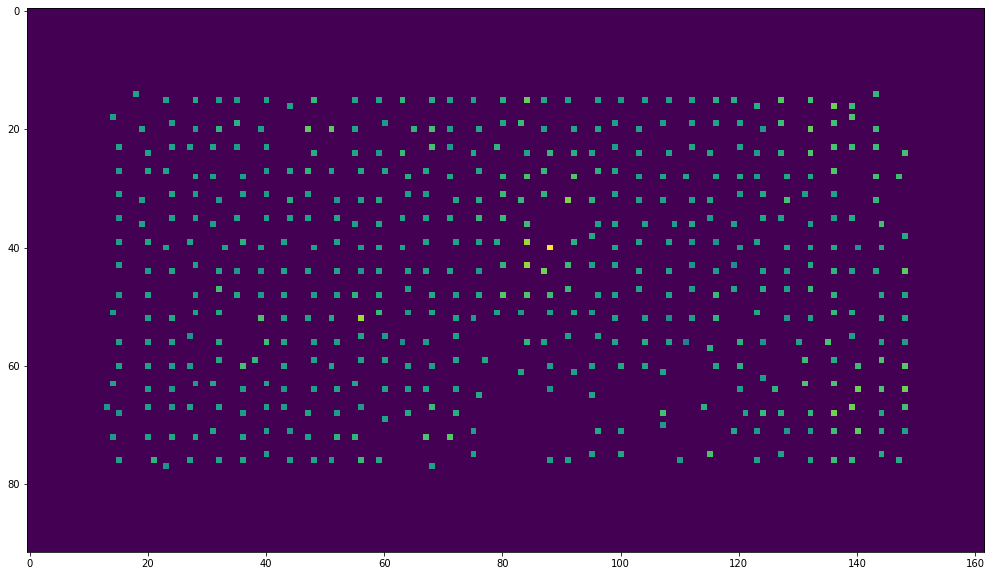

In [45]:
plt.figure(figsize=(20,10))
plt.imshow(graph.cost_rest[2])
plt.show()

In [35]:
inds_orig = graph.pos2node[np.mean(graph.cost_rest,axis=0) > 0]

In [ ]:
x, y = np.where(graph.cost_rest[2]>0)
out = np.zeros(instance_corr.shape)
for (i,j) in zip(x,y):
    if graph.pos2node[i,j]==-1:
        print(i,j)
        out[i,j] = 1

In [ ]:
graph.add_edges()

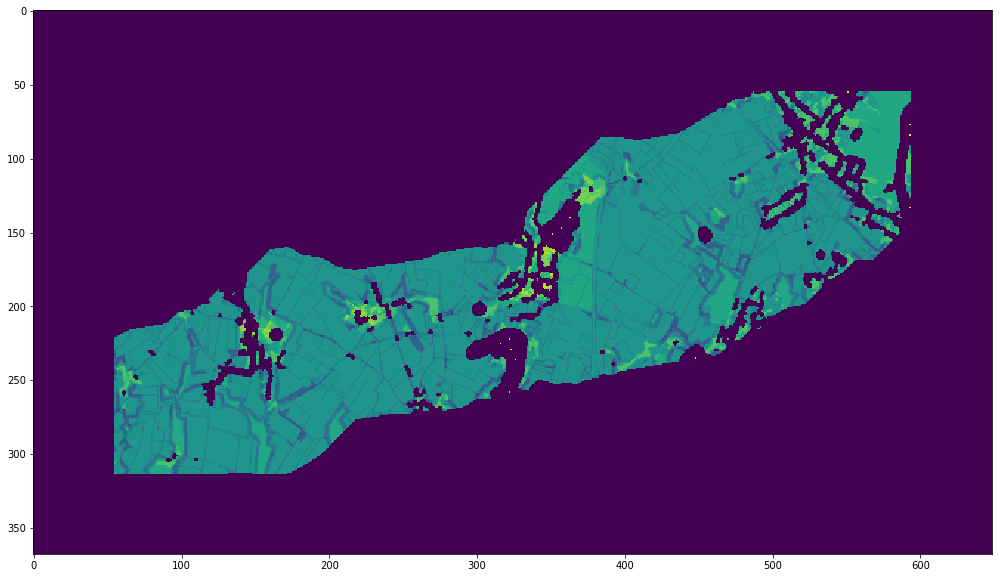

In [73]:
plt.figure(figsize=(20,10))
plt.imshow(graph.cost_rest[2])
plt.show()

### PIPELINE:

In [11]:
### Initialize graph
graph = WeightedGraph(
        instance, instance_corr, graphtool=1, verbose=1
    )
graph.set_edge_costs(LAYER_CLASSES, CLASS_WEIGHT)
graph.set_shift(PYLON_DIST_MIN, PYLON_DIST_MAX, vec, MAX_ANGLE)

initialized weighted graph pos2node
['cultural', 'human', 'planning', 'technical'] [0.28571429 0.35714286 0.14285714 0.21428571]


In [12]:
pipeline = [(2,50), (1,0)] # scale down by factor of 4, refine with distance 100, 
# then scale down by factor of 2 in this area, refine in distance of 50
# pipeline = [(2,70), (1,0)]

time downsampling: 2.094


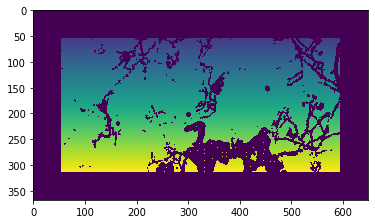

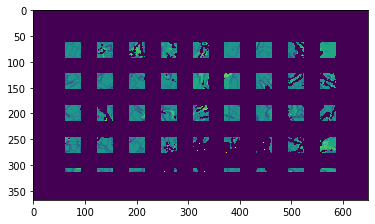

set cost rest
DONE adding 3760806 edges: 4.257081031799316
now number of edges: 14195082 vertices: 203731
start and end: 175934 64196


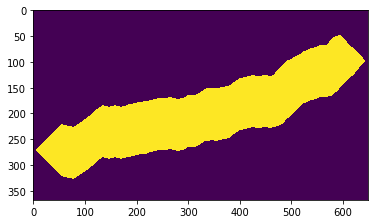

time downsampling: 0.021


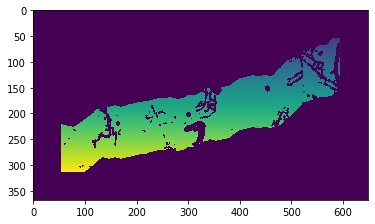

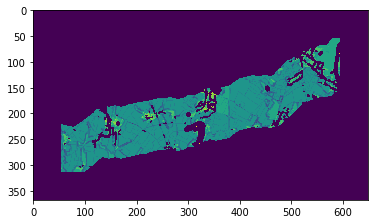

set cost rest
DONE adding 6205501 edges: 3.6757571697235107
now number of edges: 12565867 vertices: 203731
start and end: 175934 64196
DONE 114.09099388122559


In [20]:
tic = time.time()

corridor = np.ones(instance_corr.shape) # beginning: everything is included
output_paths = []

plot_surfaces = []

for (factor, dist) in pipeline:
    tic_down = time.time()
    graph.set_cost_rest(factor, corridor, start_inds, dest_inds)
    print("time downsampling:", round(time.time()-tic_down,3))
    plt.imshow(graph.pos2node)
    plt.show()
    plt.imshow(graph.cost_rest[2])
    plt.show()
    plot_surfaces.append(np.mean(graph.cost_rest, axis=0))
    print("set cost rest")
    graph.add_edges()
    print("now number of edges:", len(list(graph.graph.edges())), "vertices:", len(list(graph.graph.vertices())))
    # weighted sum of all costs
    graph.sum_costs()
    source_v, target_v = graph.add_start_and_dest(start_inds, dest_inds)
    print("start and end:", source_v, target_v)
    # get actual best path
    path, path_costs = graph.get_shortest_path(source_v, target_v)
    output_paths.append((path, path_costs)) # save for inspection
    # get several paths --> here: pareto paths
    paths = [path] # graph.get_pareto(np.arange(0, 1.1, 0.1), source_v, target_v, compare=[2, 3])
    if dist > 0:
        # do specified numer of dilations
        dist_surface = get_distance_surface(graph.pos2node.shape, paths, mode="dilation", n_dilate=dist)
        # plotting
        plt.imshow(dist_surface>0)
        plt.show()
        # remove the edges of vertices in the corridor (to overwrite)
        graph.remove_vertices((dist_surface>0).astype(int)) # PYLON_DIST_MAX
        # set new corridor
        corridor = (dist_surface >0).astype(int)

print("DONE", time.time() - tic)

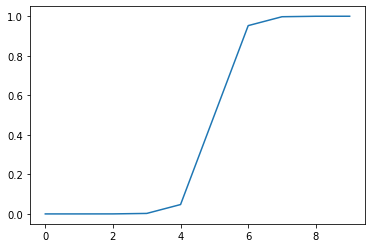

In [71]:
sm = lambda x: 1/(1+np.exp(3*(-x+5)))
plt.plot([sm(x) for x in range(10)])

In [45]:
path, path_costs = graph.get_shortest_path(source_v, target_v)

In [39]:
paths = graph.get_pareto(np.arange(0, 1.1, 0.1), source_v, target_v, compare=[2, 3])

In [40]:
dist_surface = get_distance_surface(graph.pos2node.shape, paths, mode="dilation")

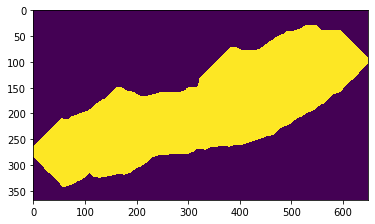

In [135]:
plt.imshow(dist_surface>30)
plt.show()

In [ ]:
# only change cost_rest, not pos2node
# use max instead of mean --> replacing the edge is always improving it
# use find_edge to determine edges with high cost?

In [41]:
graph.remove_vertices((dist_surface>30).astype(int))
graph.update_cost_rest((dist_surface>15).astype(int))

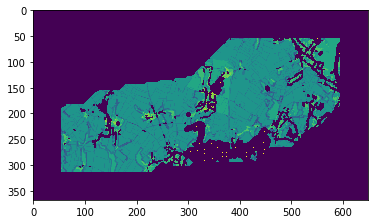

In [42]:
plt.imshow(graph.cost_rest[2])
plt.show()

In [43]:
graph.add_edges()

DONE adding 10652034 edges: 6.9997498989105225


In [44]:
graph.sum_costs()

In [109]:
a = np.array([[1,2,3], [4,5,6],[0,0,0]])

In [110]:
np.mean(a[a>0])

3.5

In [192]:
1220/60

20.333333333333332

## Graph Code

In [10]:
import numpy as np
from graph_tool.all import Graph, shortest_path, load_graph, find_edge
import time
import networkx as nx
from power_planner.utils import get_half_donut
from power_planner.plotting import plot_pareto
                

class WeightedGraph(GeneralGraph):

    def __init__(
        self,
        cost_instance,
        hard_constraints,
        directed=True,
        graphtool=1,
        verbose=1
    ):
        # assert cost_instance.shape == hard_constraints.shape
        # , "Cost size must be equal to corridor definition size!"

        # time logs
        self.time_logs = {}
        tic = time.time()

        # indicator whether to use networkx or graph tool
        self.graphtool = graphtool

        # cost surface
        self.cost_instance = cost_instance
        self.hard_constraints = hard_constraints
        self.x_len, self.y_len = hard_constraints.shape

        # initialize graph:
        GeneralGraph.__init__(
            self, directed=directed, graphtool=graphtool, verbose=verbose
        )

        # print statements
        self.verbose = verbose

        self.time_logs["init_graph"] = round(time.time() - tic, 3)
        
        # _, self.cost_rest = self.set_pos2node(self.cost_rest, 4) # self.pos2node,
        
        # original pos2node: all filled except for hard constraints
        self.pos2node_orig = np.arange(1, self.x_len*self.y_len+1).reshape((self.x_len, self.y_len))
        self.pos2node_orig *= (self.hard_constraints > 0).astype(int)
        # self.pos2node_orig[self.pos2node_orig==0] = -1
        self.pos2node_orig -= 1
        
        print("initialized weighted graph pos2node")
        
    def _get_seeds(self, greater_zero, factor):
        lab = 0
        x_len, y_len = greater_zero.shape
        seeds = np.zeros(greater_zero.shape)
        omitted = 0
        for i in np.arange(0, x_len, factor):
            for j in np.arange(0, y_len, factor):
                if greater_zero[i, j]:
                    seeds[i, j] = lab
                    lab += 1
                else:
                    omitted += 1
        print("omitted:", omitted)
        return seeds
        
    def _watershed_transform(self, cost_rest, factor, compact=0.01, mode="center"):
        """
        :param mode: all = all combinations in one cluster possible
                --> leading to larger distances
                center = only the center of each cluster can be connected
        """
        tic = time.time()
        img = np.mean(cost_rest, axis=0) # take mean image for clustering TODO: weighted sum?

        greater_zero = (img > 0).astype(int)
        
        edges = filters.sobel(img)

        seeds = self._get_seeds(greater_zero, factor)
        if self.verbose:
            print("number seeds: ", np.sum(seeds > 0))

        w1 = watershed(edges, seeds, compactness=compact)
        # w1 is full watershed --> labels spread over corridor borders
        # but: label 0 also included --> +1 before corridor
        w1_g_zero = (w1 + 1) * greater_zero
        # labels: 0 is forbidden, 1 etc is watershed labels
        labels = np.unique(w1_g_zero)
        
        new_cost_rest = np.zeros(cost_rest.shape)
        # iterate over labels (except for 0 - forbidden)
        for i, lab in enumerate(labels[1:]):
            inds = w1_g_zero == lab
            
            # , lab in enumerate(labels):
            x_inds, y_inds = np.where(w1_g_zero == lab)
            for j in range(len(cost_rest)):
                new_cost_rest[j,
                              int(np.mean(x_inds)),
                              int(np.mean(y_inds))] = np.mean(
                                  cost_rest[j, x_inds, y_inds]
                              )
        return new_cost_rest
        
    def downsample(self, img, factor):
        x_len_new = img.shape[1] // factor
        y_len_new = img.shape[2] // factor
        new_img = np.zeros(img.shape)
        for i in range(x_len_new):
            for j in range(y_len_new):
                patch = img[:, i * factor:(i + 1) * factor, j * factor:(j + 1) * factor]
                if np.any(patch): # >0.01):
                    for k in range(len(new_img)):
                        part = patch[k]
                        if np.any(part): # >0.01):
                            new_img[k, i*factor, j*factor] = np.min(part[part>0]) # >0.01])
        return new_img
        
    def set_cost_rest(self, factor, corridor, start_inds, dest_inds):
        self.cost_rest = self.cost_instance * (self.hard_constraints > 0).astype(int) * corridor
        
        # downsample
        if factor>1:
            self.cost_rest = self.downsample(self.cost_rest, factor)
        # else:
        #     self.cost_rest = self.cost_instance
        # repeat because edge artifacts
        self.cost_rest = self.cost_rest * (self.hard_constraints > 0).astype(int) * corridor
        
        # add start and end TODO ugly
        graph.cost_rest[:, dest_inds[0], dest_inds[1]] = instance[:, dest_inds[0], dest_inds[1]]
        graph.cost_rest[:, start_inds[0], start_inds[1]] = instance[:, start_inds[0], start_inds[1]]
        
        # define pos2node accordingly:
        inverted_corridor = np.absolute(1-corridor).astype(bool)
        self.pos2node = self.pos2node_orig.copy()
        self.pos2node[inverted_corridor] = -1 # set all which are not in the corridor to -1
        
        
    def update_cost_rest(self, corridor):
        # UNUSED method
        inverted_corridor = np.absolute(1-corridor).astype(bool)
        self.pos2node[inverted_corridor] = -1
        
    def set_pos2node(self, img, factor):
        # UNUSED METHOD
        x_len_new = img.shape[1] // factor
        y_len_new = img.shape[2] // factor
        pos2node = np.zeros((img.shape[1], img.shape[2]))
        new_img = np.zeros(img.shape)
        pos2node += -1
        lab = 0
        for i in range(x_len_new):
            for j in range(y_len_new):
                patch = img[:, i * factor:(i + 1) * factor, j * factor:(j + 1) * factor]
                if np.any(patch):
                    pos2node[i * factor:(i + 1) * factor, j * factor:(j + 1) * factor] = lab
                    lab += 1
                # x_cost = int(mean([i * factor, (i + 1) * factor])
                    for k in range(len(new_img)):
                        part = patch[k]
                        if np.any(part):
                            new_img[k, i*factor, j*factor] = np.mean(part[part>0])
        return pos2node, new_img

    def set_shift(self, lower, upper, vec, max_angle):
        GeneralGraph.set_shift(self, lower, upper, vec, max_angle)
        self.shift_vals = get_donut_vals(self.shifts, vec)

    def add_nodes(self):
        tic = time.time()
        # add nodes to graph
        n_nodes = len(np.unique(self.pos2node))
        GeneralGraph.add_nodes(self, n_nodes)
        self.time_logs["add_nodes"] = round(time.time() - tic, 3)

    def _update_time_logs(
        self, times_add_edges, times_edge_list, tic_function
    ):
        self.time_logs["add_edges"] = round(np.mean(times_add_edges), 3)
        self.time_logs["add_edges_times"] = times_add_edges

        self.time_logs["edge_list"] = round(np.mean(times_edge_list), 3)
        self.time_logs["edge_list_times"] = times_edge_list

        self.time_logs["add_all_edges"] = round(time.time() - tic_function, 3)

    def _compute_edge_costs(self, shift_index):
        # switch axes for shift
        cost_rest_switched = np.moveaxis(self.cost_rest, 0, -1)
        # shift by shift
        costs_shifted = ConstraintUtils.shift_surface(
            cost_rest_switched, self.shifts[shift_index]
        )
        # switch axes back
        costs_shifted = np.moveaxis(costs_shifted, -1, 0)

        weights = (costs_shifted + self.cost_rest) / 2
        # new version: edge weights
        # weights = convolve_faster(self.cost_rest, kernels[i], posneg[i])
        # weights = weights1 + 2 * weights2
        # print(
        #     "max node weights", np.max(weights1), "max edge weights:",
        #     np.max(weights2), "min node weights", np.min(weights1),
        #     "min edge weights:", np.min(weights2)
        # )
        
        mean_costs_shifted = np.mean(costs_shifted,axis=0) > 0

        inds_shifted = self.pos2node[mean_costs_shifted]
        # delete the ones where inds_shifted is zero

        # take weights of the shifted ones
        weights_arr = np.array(
            [w[mean_costs_shifted] for i, w in enumerate(weights)]
        )

        return inds_shifted, weights_arr

    def add_edges(self):
        tic_function = time.time()
        inds_orig = self.pos2node[np.mean(self.cost_rest,axis=0) > 0]
        
        n_edges = 0
        # kernels, posneg = get_kernel(self.shifts, self.shift_vals)
        # edge_array = []

        times_edge_list = []
        times_add_edges = []

        for i in range(len(self.shifts)):

            tic_edges = time.time()

            # compute shift and weights
            inds_shifted, weights_arr = self._compute_edge_costs(i)
            assert len(inds_shifted) == len(
                inds_orig
            ), "orig:{},shifted:{}".format(len(inds_orig), len(inds_shifted))
            
            # concatenete indices and weights, select feasible ones
            inds_arr = np.asarray([inds_orig, inds_shifted])
            inds_weights = np.concatenate((inds_arr, weights_arr), axis=0)
            pos_inds = inds_shifted >= 0
            out = np.swapaxes(inds_weights, 1, 0)[pos_inds]

            # remove edges with high costs:
            # first two columns of out are indices
            # weights_arr = np.mean(out[:, 2:], axis=1)
            # weights_mean = np.quantile(weights_arr, 0.9)
            # inds_higher = np.where(weights_arr < weights_mean)
            # out = out[inds_higher[0]]
            if np.any(out[:2].flatten()==-1):
                print(np.where(out[:2]==-1))
                raise RuntimeError

            n_edges += len(out)
            times_edge_list.append(round(time.time() - tic_edges, 3))

            # add edges to graph
            tic_graph = time.time()
            if self.graphtool:
                self.graph.add_edge_list(out, eprops=self.cost_props)
            else:
                nx_edge_list = [(e[0], e[1], {"weight": e[2]}) for e in out]
                self.graph.add_edges_from(nx_edge_list)
            times_add_edges.append(round(time.time() - tic_graph, 3))

            # alternative: collect edges here and add alltogether
            # edge_array.append(out)
            
        # # alternative: add edges all in one go
        # tic_concat = time.time()
        # edge_lists_concat = np.concatenate(edge_array, axis=0)
        # self.time_logs["concatenate"] = round(time.time() - tic_concat, 3)
        # print("time for concatenate:", self.time_logs["concatenate"])
        # tic_graph = time.time()
        # self.graph.add_edge_list(edge_lists_concat, eprops=[self.weight])
        # self.time_logs["add_edges"] = round(
        #     (time.time() - tic_graph) / len(shifts), 3
        # )

        self._update_time_logs(times_add_edges, times_edge_list, tic_function)
        if self.verbose:
            print("DONE adding", n_edges, "edges:", time.time() - tic_function)
            
    def remove_vertices(self, corridor):
        ## Possibility 1: remove all edges of vertices in the (smaller) corridor 
        # corr_vertices = self.pos2node * corridor
        # new_vertices = corr_vertices[corr_vertices>0]
        # for v in new_vertices:
        #     self.graph.clear_vertex(self.graph.vertex(v))
        ## Possibility 2: remove all edges --> only considering corridor then
        # self.graph.clear_edges()
        ## Possibility 3: remove all out_edges of corridor vertices (inefficient probably)
        corr_vertices = self.pos2node * corridor
        new_vertices = corr_vertices[corr_vertices>0]
        remove_property = self.graph.new_edge_property("float")
        remove_property.a = np.zeros(self.weight.get_array().shape)
        for v in new_vertices:
            for e in self.graph.vertex(v).out_edges():
                remove_property[e] = 1
        remove_labeled_edges(self.graph, remove_property)

    def add_start_and_dest(self, start_inds, dest_inds):
        start_node_ind = self.pos2node[start_inds[0], start_inds[1]]
        dest_node_ind = self.pos2node[dest_inds[0], dest_inds[1]]
        if self.graphtool:
            return self.graph.vertex(start_node_ind
                                     ), self.graph.vertex(dest_node_ind)
        else:
            return start_node_ind, dest_node_ind
    
    def get_shortest_path(self, source, target):
        """
        Compute shortest path from source vertex to target vertex
        """
        tic = (time.time())
        # #if source and target are given as indices:
        vertices_path = GeneralGraph.get_shortest_path(self, source, target)
        
        path = []
        for v in vertices_path:
            if self.graphtool:
                ind = self.graph.vertex_index[v]
            else:
                ind = int(v)
            path.append((ind//self.y_len, ind%self.y_len))
        
        # if self.verbose:
        #     print("time for shortest path", time.time() - tic)

        self.time_logs["shortest_path"] = round(time.time() - tic, 3)

        # compute edge costs
        out_costs = []
        for (i, j) in path:
            out_costs.append(self.cost_instance[:, i, j].tolist())
        # TODO: append graph.weight[edge]?

        return path, out_costs
    
    def get_shortest_path_old(self, source, target):
        tic = time.time()

        # compute shortest path
        vertices_path, _ = shortest_path(
            self.graph,
            source,
            target,
            weights=self.weight,
            negative_weights=True
        )
        # else:
        #     vertices_path = nx.dijkstra_path(self.graph, source, target)

        # transform path
        path = []
        out_costs = []
        for v in vertices_path:
            v_ind = self.graph.vertex_index[v]
            x_inds, y_inds = np.where(self.pos2node == v_ind)
            # find minimum value field out of possible
            
            min_ind_x = int(np.mean(x_inds))
            min_ind_y = int(np.mean(y_inds))

            path.append((min_ind_x, min_ind_y))
            out_costs.append(self.cost_rest[:, min_ind_x, min_ind_y].tolist())
        
        self.time_logs["shortest_path"] = round(time.time() - tic, 3)

        return path, out_costs
    

In [5]:
class GeneralGraph():

    def __init__(self, graphtool=1, directed=True, verbose=1):
        if graphtool:
            self.graph = Graph(directed=directed)
            self.weight = self.graph.new_edge_property("float")
        else:
            if directed:
                print("directed graph")
                self.graph = nx.DiGraph()
            else:
                self.graph = nx.Graph()
        self.time_logs = {}
        self.verbose = verbose
        self.graphtool = graphtool

    def set_edge_costs(self, classes, weights=None):
        if weights is None:
            weights = [1 for i in range(len(classes))]
        weights = np.array(weights)
        # set different costs:
        self.cost_classes = classes
        self.cost_props = [
            self.graph.new_edge_property("float") for _ in range(len(classes))
        ]
        self.cost_weights = weights / np.sum(weights)
        print(self.cost_classes, self.cost_weights)

    def set_shift(self, lower, upper, vec, max_angle):
        self.shifts = get_half_donut(lower, upper, vec, angle_max=max_angle)

    def add_nodes(self, nodes):
        """
        param nodes: list of node names if networkx, integer if graphtool
        """
        tic = time.time()
        # add nodes to graph
        if self.graphtool:
            _ = self.graph.add_vertex(nodes)
        else:
            self.graph.add_nodes_from(np.arange(nodes))
        # verbose
        if self.verbose:
            print("Added nodes:", nodes, "in time:", time.time() - tic)
        self.time_logs["add_nodes"] = round(time.time() - tic, 3)

    def sum_costs(self):
        # add sum of all costs
        tic = time.time()
        summed_costs_arr = np.zeros(self.cost_props[0].get_array().shape)
        for i in range(len(self.cost_props)):
            prop = self.cost_props[i].get_array()
            summed_costs_arr += prop * self.cost_weights[i]
        self.weight.a = summed_costs_arr

        self.time_logs["sum_of_costs"] = round(time.time() - tic, 3)

    def get_pareto(self, vary, source, dest, out_path=None, compare=[0, 1]):
        """
        compute shortest paths with varied weights
        """
        pareto = list()
        paths = list()
        cost0 = self.cost_props[compare[0]].get_array()
        cost1 = self.cost_props[compare[1]].get_array()
        class0 = self.cost_classes[compare[0]]
        class1 = self.cost_classes[compare[1]]
        # test_edge = find_edge(self.graph, self.graph.edge_index, 44)[0]
        for w in vary:
            self.weight.a = cost0 * w + cost1 * (1 - w)
            # print("test weight", self.weight[test_edge])
            path, path_costs = self.get_shortest_path(source, dest)
            # print(
            #     class0, "weight:", w, class1, "weight:", 1 - w, "costs:",
            #     np.mean(path_costs, axis=0)
            # )
            pareto.append(np.sum(path_costs, axis=0))
            paths.append(path)
        # PLOTTING:
        # pareto = np.asarray(pareto)
        # pareto0 = pareto[:, compare[0]]
        # pareto1 = pareto[:, compare[1]]
        # plot_pareto(
        #     pareto0, pareto1, paths, vary, [class0, class1], out_path=out_path
        # )
        # plot_pareto_paths(paths, [class0, class1], out_path=out_path)
        return paths

    def get_shortest_path(self, source, target):
        """
        Compute shortest path from source vertex to target vertex
        """
        tic = (time.time())
        # #if source and target are given as indices:
        if self.graphtool:
            vertices_path, _ = shortest_path(
                self.graph,
                source,
                target,
                weights=self.weight,
                negative_weights=True
            )
        else:
            vertices_path = nx.dijkstra_path(self.graph, source, target)

        self.time_logs["shortest_path"] = round(time.time() - tic, 3)
        return vertices_path

    def save_graph(self, OUT_PATH):
        if self.graphtool:
            for i, cost_class in enumerate(self.cost_classes):
                self.graph.edge_properties[cost_class] = self.cost_props[i]
            self.graph.edge_properties["weight"] = self.weight
            self.graph.save(OUT_PATH + ".xml.gz")
        else:
            nx.write_weighted_edgelist(
                self.graph, OUT_PATH + '.weighted.edgelist'
            )

    def load_graph(self, IN_PATH):
        if self.graphtool:
            self.g_prev = load_graph(IN_PATH + ".xml.gz")
            self.weight_prev = self.g_prev.ep.weight
            # weight = G2.ep.weight[G2.edge(66, 69)]
        else:
            self.g_prev = nx.read_edgelist(
                IN_PATH + '.weighted.edgelist',
                nodetype=int,
                data=(('weight', float), )
            )

# Evaluation

out costs shape: (51, 4)
instance shape (4, 368, 649)


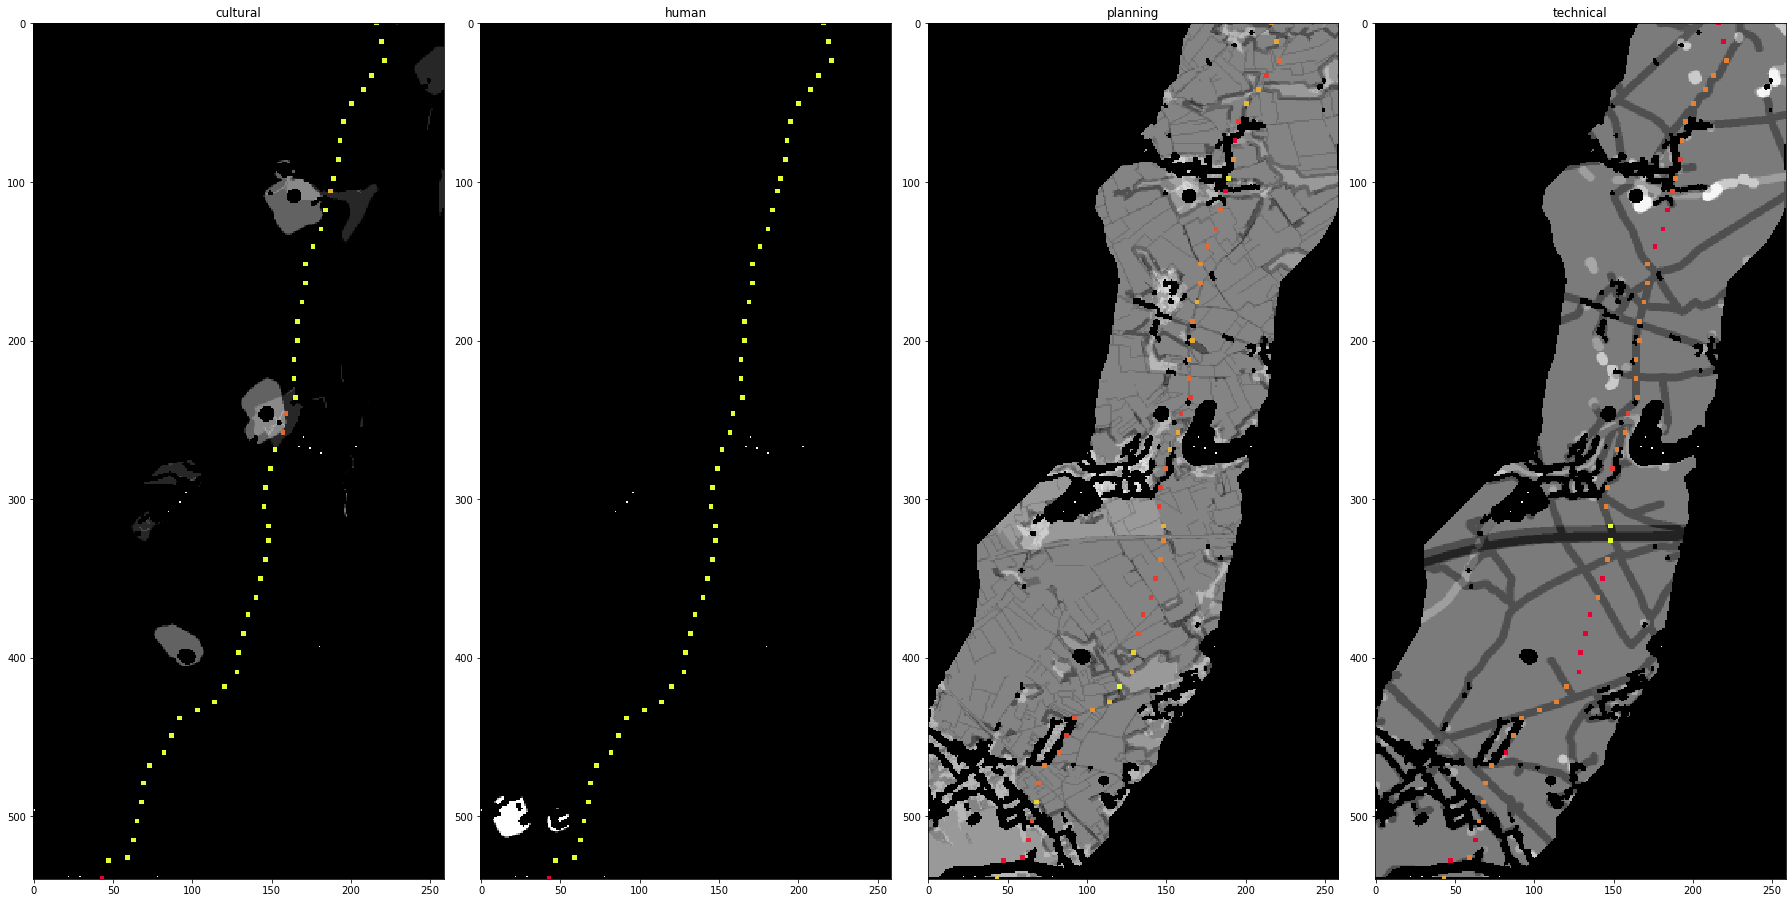

In [74]:
plot_path_costs(graph.cost_rest, (np.array(infos["path_cells"])/2).astype(int), infos["edgecosts"], graph.cost_classes)

In [ ]:
linear infrastructure, optimal path planning, network OPTLINE, optimal power transport by LOPT LION 
optimal power transport infrastructure by LIOPT graph modeling 

In [106]:
np.sum(np.array(output_paths[-1][1]), axis=0)

array([ 0.64433816,  0.25997277, 21.14497277, 17.99635208])

In [24]:
def plot_pipeline_paths(plot_surfaces, output_paths, buffer=1, out_path=None):
    """
    subplots of different steps in the pipeline
    """
    plt.figure(figsize=(20, 10))
    for i, (p, p_cost) in enumerate(output_paths):
        plt.subplot(1, len(output_paths), i + 1)

        # expand to greyscale
        expanded = np.expand_dims(plot_surfaces[i], axis=2)
        expanded = np.tile(
            expanded, (1, 1, 3)
        )  # overwrite instance by tiled one
        # colour nodes in path in red
        for (x, y) in p:
            expanded[x - buffer:x + buffer + 1, y - buffer:y + buffer +
                     1] = [0.9, 0.2, 0.2]  # colour red
        plt.imshow(np.swapaxes(expanded, 1, 0), origin="lower")
        print("costs", np.sum(np.array(p_cost), axis=0))
    plt.tight_layout()
    if out_path is not None:
        plt.savefig(out_path, bbox_inches='tight')
    else:
        plt.show()

costs [ 0.56261891  0.2549266  21.9249266  18.87561625]
costs [ 0.63954198  0.2549266  21.1449266  17.99630591]


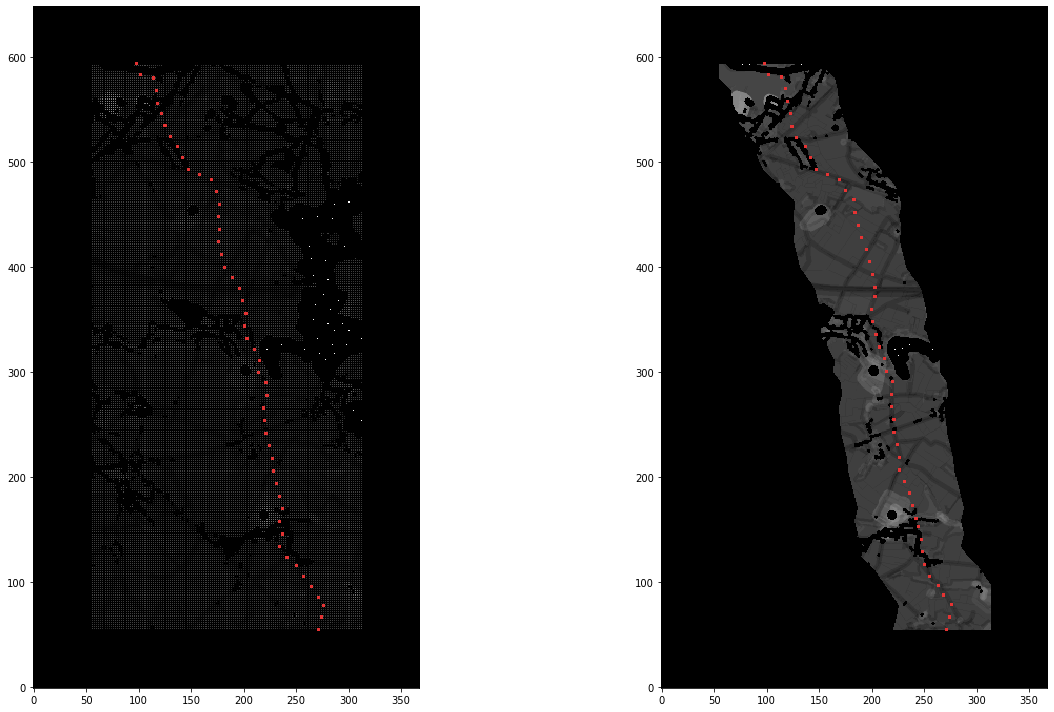

In [25]:
plot_pipeline_paths(plot_surfaces, output_paths, buffer=1, out_path=None)

In [87]:
gt = np.array(infos["path_cells"])
costs_new = []
for i in range(len(gt)-1):
    (h,j) = gt[i]
    (k,l) = gt[i+1]
    v1 = graph.pos2node[int(h//2), j//2]
    v2 = graph.pos2node[int(k//2), l//2]
    found=False
    for w in graph.graph.vertex(v1).out_neighbors():
        if w==v2:
            found=True
    # print(found)
    e = graph.graph.edge(graph.graph.vertex(v1), graph.graph.vertex(v2))
    c = [cost[e] for cost in graph.cost_props]
    costs_new.append(c)

In [88]:
np.sum(np.array(costs_new), axis=0)

array([ 0.51680177,  0.13243639, 20.84248639, 17.62748639])

### Tests:

In [ ]:
# TEST THAT EDGES ARE NOT OVERWRITTEN - MULTIGRAPH
g = Graph()
w = g.new_edge_property("float")
edges = []
for i in range(20):
    edges.append([i,i+1,i])
g.add_edge_list(edges, eprops=[w])
# e = find_edge(g, g.edge_index, 13)

new_edges = []
for i in range(15,20):
    new_edges.append([i,i+1,i-5])
g.add_edge_list(new_edges, eprops=[w])

e = g.add_edge(g.vertex(13), g.vertex(14))
w[e] = 10

for e in g.edges():
    print(e)
    print(w[e])